## **Feasibility Test of Pre-trained SSD MobileNet Model for ML Use Case 1**

In this notebook, we are exploring the feasibility of using a pre-trained SSD MobileNet V2 model for detecting potholes in the RDD2022 dataset. Our focus is on annotated images from Japan, and we aim to verify the model's performance before custom training. 

- **Model Loading:** Utilized TensorFlow Hub to load the SSD MobileNet V2 model.
- **Image Preprocessing:** Implemented functions for image preprocessing and drawing bounding boxes on detected objects.
- **Sample Image Testing:** Conducted tests using sample images to visualize the model's detection capabilities.
- **Feasibility Evaluation:** This step is crucial to ensure that the pre-trained model can identify potholes (label code: D40) effectively, laying the groundwork for further custom training and dataset curation.


### **1. Download and import necessary libraries**

In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install tensorflow-hub

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image, ImageColor, ImageDraw, ImageFont, ImageOps
import pandas as pd
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

### **2. Apply SSD Mobilenet module for sample images**

In [4]:
print(tf.__version__)
print(hub.__version__)

2.16.1
0.16.1


#### Model Loading

In [5]:
ssd_url = "https://kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow1/variations/openimages-v4-ssd-mobilenet-v2/versions/1"

In [6]:
ssd_model = hub.load(ssd_url)
ssd_detector = ssd_model.signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


#### Image Visualization and Preprocessing

In [7]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

In [8]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    bbox = font.getbbox(display_str)
    text_width, text_height = bbox[2], bbox[3]
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

In [9]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [10]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels = 3)
    return img

#### Sample Image Testing

In [11]:
def run_detector(detector, path):
    img = load_img(path)
    converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    result = detector(converted_img)

    result = {key:value.numpy() for key, value in result.items()}
    print("Found %d objects." % len(result["detection_scores"]))

    image_with_boxes = draw_boxes(
        img.numpy(), result["detection_boxes"], result["detection_class_entities"], result["detection_scores"])
    display_image(image_with_boxes)

Found 100 objects.
Font not found, using default font.


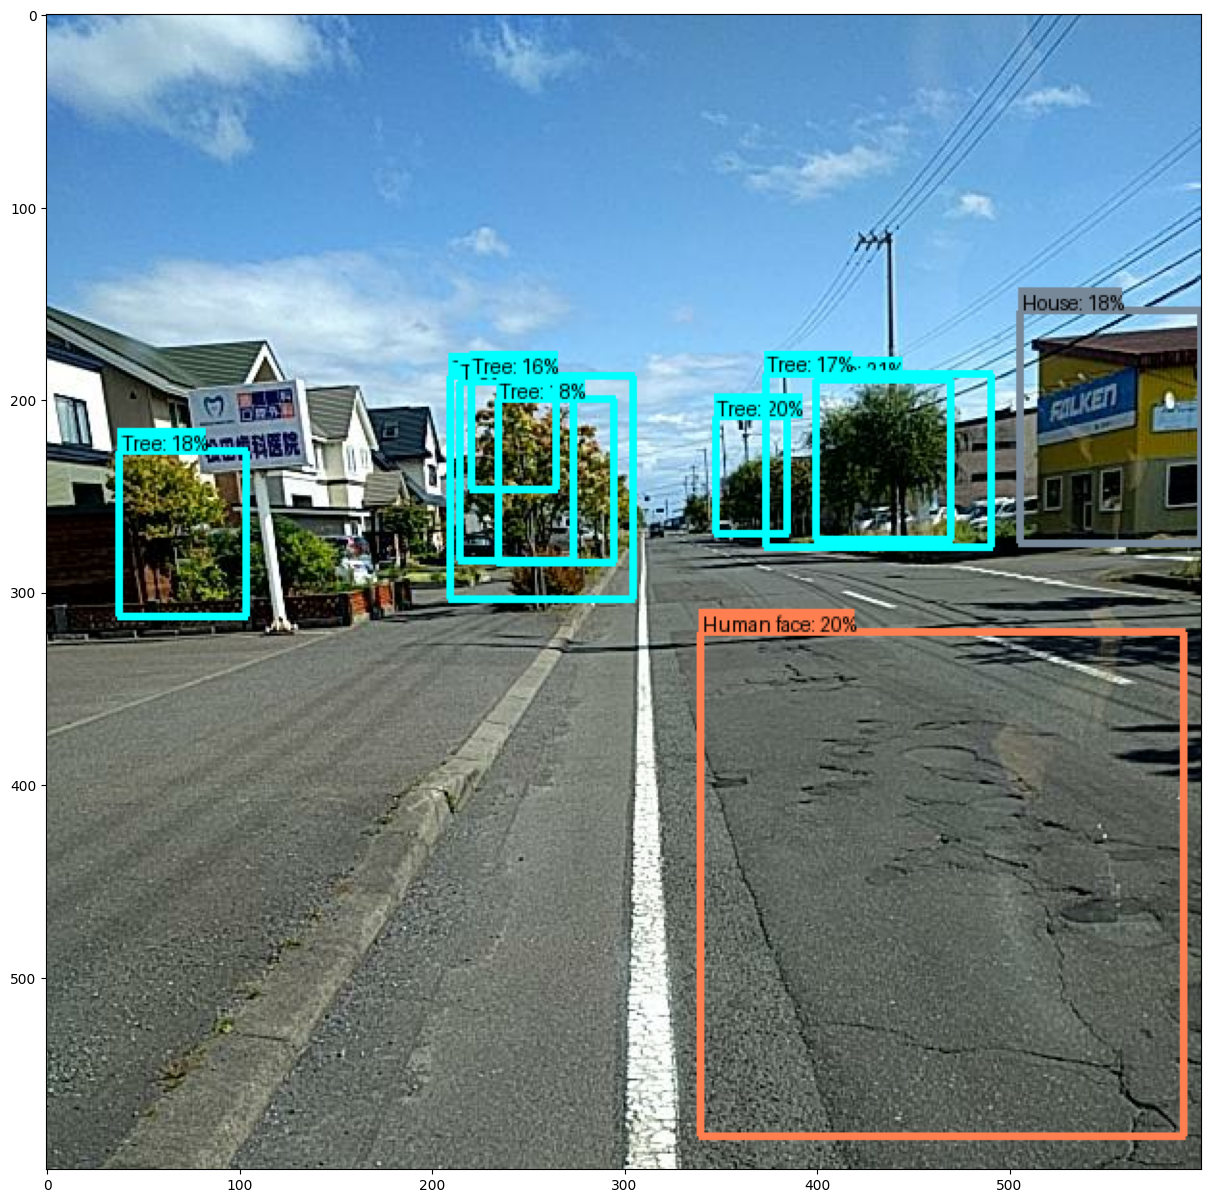

In [12]:
sample_image = "../RDD2022/RDD2022_all_countries/Japan/Japan/train/images/Japan_000000.jpg"
run_detector(ssd_detector, sample_image)